<a href="https://colab.research.google.com/github/ramtiin/Predicting-Stock-Prices-Using-FB-Prophet/blob/main/Stock%20Market%20Forecasting%20Using%20FB-Prohet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
from fbprophet import Prophet
import matplotlib.pyplot as plt
 
%matplotlib inline
 
plt.rcParams['figure.figsize']=(16,8)
plt.style.use('ggplot')

In [2]:
prices_df = pd.read_csv('GOOG.csv', index_col='Date', parse_dates=True)
prices_df = prices_df.loc['2017-01-01':,:]

idx = pd.date_range(prices_df.index.min(), prices_df.index.max(), freq='D')
prices_df = prices_df.reindex(idx)
prices_df = prices_df[['Close']]
prices_df = prices_df.rename_axis('Date')

test_size = 100

data_train = prices_df.iloc[:-test_size, :]
data_test = prices_df.iloc[-test_size:, :]

In [3]:
prices_df 

,Close
Date,
2017-01-03,786.140015
2017-01-04,786.900024
2017-01-05,794.020020
2017-01-06,806.150024
2017-01-07,NaN
...,...
2021-05-24,2406.669922
2021-05-25,2409.070068
2021-05-26,2433.530029


In [4]:
data_train.describe()

,Close
count,1038.000000
mean,1198.648664
std,259.151137
min,786.140015
25%,1032.502502
50%,1147.309998
75%,1335.822510
max,2128.310059


,ds,y
1502,2021-02-13,NaN
1503,2021-02-14,NaN
1504,2021-02-15,NaN
1505,2021-02-16,2121.899902
1506,2021-02-17,2128.310059


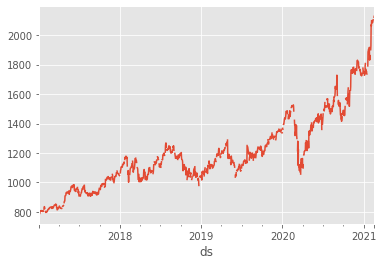

In [5]:
df = data_train.reset_index()
df=df.rename(columns={'Date':'ds', 'Close':'y'})
df['ds'] = pd.to_datetime(df['ds'])
df.set_index('ds').y.plot()
df.tail(5)

In [6]:
model = Prophet(daily_seasonality=True)
model.fit(df)

In [7]:
future = model.make_future_dataframe(periods= int((data_test.index[-1] - data_train.index[-1]).days),freq = 'd')
future.tail(14)

,ds
1593,2021-05-15
1594,2021-05-16
1595,2021-05-17
1596,2021-05-18
1597,2021-05-19
1598,2021-05-20
1599,2021-05-21
1600,2021-05-22
1601,2021-05-23
1602,2021-05-24


In [8]:
# Eliminate weekend from future dataframe
future['day'] = future['ds'].dt.weekday
future = future[(future['day']<5)]
future.tail(14)

,ds,day
1589,2021-05-11,1
1590,2021-05-12,2
1591,2021-05-13,3
1592,2021-05-14,4
1595,2021-05-17,0
1596,2021-05-18,1
1597,2021-05-19,2
1598,2021-05-20,3
1599,2021-05-21,4
1602,2021-05-24,0


In [9]:
forecast = model.predict(future)

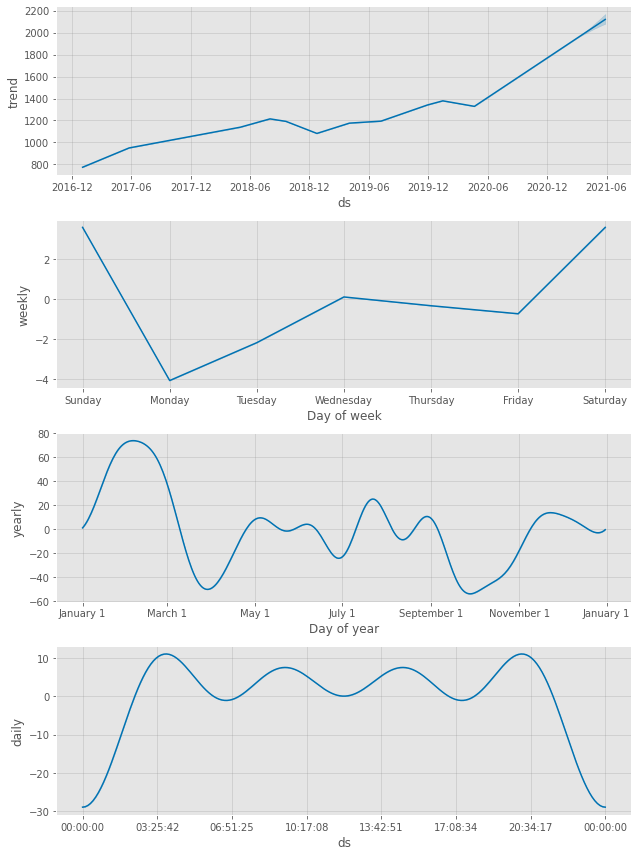

In [10]:
fig = model.plot_components(forecast)

In [11]:
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

,ds,yhat,yhat_lower,yhat_upper
0,2017-01-03,747.448709,679.015450,817.565541
1,2017-01-04,752.943592,681.877490,819.269030
2,2017-01-05,755.921833,690.263209,827.409364
3,2017-01-06,759.150962,692.383625,828.325410
4,2017-01-09,767.786890,699.136818,831.934882
...,...,...,...,...
1144,2021-05-24,2077.433277,1992.727988,2164.231735
1145,2021-05-25,2081.471742,1995.375061,2168.113662
1146,2021-05-26,2086.030883,2006.808900,2172.908825
1147,2021-05-27,2087.960871,2006.530959,2180.966458


In [12]:
new_df = df.set_index('ds')
new_forecast = forecast.set_index('ds')
viz_df = prices_df.join(new_forecast[['yhat', 'yhat_lower','yhat_upper']], how = 'outer')

In [13]:
viz_df

,Close,yhat,yhat_lower,yhat_upper
2017-01-03,786.140015,747.448709,679.015450,817.565541
2017-01-04,786.900024,752.943592,681.877490,819.269030
2017-01-05,794.020020,755.921833,690.263209,827.409364
2017-01-06,806.150024,759.150962,692.383625,828.325410
2017-01-07,NaN,NaN,NaN,NaN
...,...,...,...,...
2021-05-24,2406.669922,2077.433277,1992.727988,2164.231735
2021-05-25,2409.070068,2081.471742,1995.375061,2168.113662
2021-05-26,2433.530029,2086.030883,2006.808900,2172.908825
2021-05-27,2402.510010,2087.960871,2006.530959,2180.966458


In [14]:
prices_df.index = pd.to_datetime(prices_df.index) #make sure our index as a datetime object
connect_date = data_train.index[-2] #select the 2nd to last date
connect_date

Timestamp('2021-02-16 00:00:00', freq='D')

In [15]:
mask = (new_forecast.index > connect_date)
predict_df = new_forecast.loc[mask]

In [16]:
predict_df.head()

,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
ds,,,,,,,,,,,,,,,,,,,,,
2021-02-17,1923.216472,1891.065967,2029.734018,1923.216472,1923.216472,38.152408,38.152408,38.152408,-28.912841,-28.912841,-28.912841,0.112857,0.112857,0.112857,66.952392,66.952392,66.952392,0.0,0.0,0.0,1961.368880
2021-02-18,1925.184963,1889.351264,2034.070216,1925.184963,1925.184963,36.341467,36.341467,36.341467,-28.912841,-28.912841,-28.912841,-0.329108,-0.329108,-0.329108,65.583416,65.583416,65.583416,0.0,0.0,0.0,1961.526430
2021-02-19,1927.153454,1888.621544,2024.875205,1927.153454,1927.153454,34.395966,34.395966,34.395966,-28.912841,-28.912841,-28.912841,-0.732637,-0.732637,-0.732637,64.041444,64.041444,64.041444,0.0,0.0,0.0,1961.549419
2021-02-22,1933.058925,1891.785480,2028.527437,1933.058925,1933.058925,25.252803,25.252803,25.252803,-28.912841,-28.912841,-28.912841,-4.092537,-4.092537,-4.092537,58.258181,58.258181,58.258181,0.0,0.0,0.0,1958.311728
2021-02-23,1935.027416,1892.416468,2027.119565,1935.027416,1935.027416,24.812207,24.812207,24.812207,-28.912841,-28.912841,-28.912841,-2.186785,-2.186785,-2.186785,55.911833,55.911833,55.911833,0.0,0.0,0.0,1959.839623


In [17]:
viz_df = prices_df.join(predict_df[['yhat', 'yhat_lower','yhat_upper']], how = 'outer')
viz_df.tail(10)

,Close,yhat,yhat_lower,yhat_upper
2021-05-19,2308.709961,2073.061252,1989.665706,2154.548841
2021-05-20,2356.090088,2074.062068,1993.065011,2157.146599
2021-05-21,2345.100098,2075.231511,1991.245555,2153.469100
2021-05-22,NaN,NaN,NaN,NaN
2021-05-23,NaN,NaN,NaN,NaN
2021-05-24,2406.669922,2077.433277,1992.727988,2164.231735
2021-05-25,2409.070068,2081.471742,1995.375061,2168.113662
2021-05-26,2433.530029,2086.030883,2006.808900,2172.908825
2021-05-27,2402.510010,2087.960871,2006.530959,2180.966458
2021-05-28,2411.560059,2090.023271,2000.168715,2176.921106


In [18]:
viz_df.tail(10)

,Close,yhat,yhat_lower,yhat_upper
2021-05-19,2308.709961,2073.061252,1989.665706,2154.548841
2021-05-20,2356.090088,2074.062068,1993.065011,2157.146599
2021-05-21,2345.100098,2075.231511,1991.245555,2153.469100
2021-05-22,NaN,NaN,NaN,NaN
2021-05-23,NaN,NaN,NaN,NaN
2021-05-24,2406.669922,2077.433277,1992.727988,2164.231735
2021-05-25,2409.070068,2081.471742,1995.375061,2168.113662
2021-05-26,2433.530029,2086.030883,2006.808900,2172.908825
2021-05-27,2402.510010,2087.960871,2006.530959,2180.966458
2021-05-28,2411.560059,2090.023271,2000.168715,2176.921106


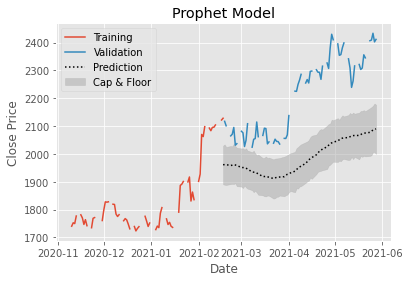

In [19]:
#viz = viz_df.iloc[-400:,:]
fig, ax1 = plt.subplots()
ax1.plot(data_train.iloc[-100:,:].Close)
ax1.plot(data_test.Close)
ax1.plot(predict_df.yhat, color='black', linestyle=':')
ax1.fill_between(predict_df.index, predict_df['yhat_upper'], predict_df['yhat_lower'], alpha=0.5, color='darkgray')
ax1.set_title('Prophet Model')
ax1.set_ylabel('Close Price')
ax1.set_xlabel('Date')
L=ax1.legend(['Training', 'Validation','Prediction', 'Cap & Floor' ]) #get the legend


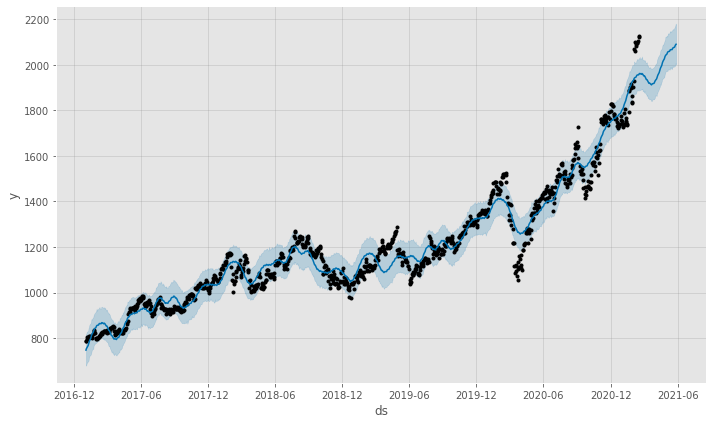

In [20]:
fig1 = model.plot(forecast)

In [21]:
from fbprophet.plot import plot_plotly
import plotly.offline as py
fig = plot_plotly( model, forecast)  
py.iplot(fig)